# Retail Returns Data Analysis Project
For a dataset generated by Gurudatt Bhobe, founder of supply.ai.

The tools used for this project were pandas, numpy, matplotlib.pyplot and sklearn.

This notebook is separated into 6 parts that show my thought process and final results. 


## *Part 1*
I first viewed the original Dataset in MS Excel to analyze what features were given and their datatypes. Of the original number of features (103), roughly half of them were very, very likely to be useless or extremely hard to make use of. This is broken down in the large multi-line comment above the list 'unhelpfulFeatures.' I removed these before proceeding. I then took some of the useful features that could be converted to numerical format and made those changes. After that, I separated all of the quantitative features into a separate fram 'quantFrame' in order to perform some basic statistical analysis (pairwise correlation, predictivness). This was primarily to weed out features that were highly correlated and to see what features, if any, seemed to predict the outcome well. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# load up half of the dataset to be the training set (accidentally picked the second half but whatever)
trainFrame = pd.read_csv("Dataset.csv").loc[50000:]

"""
Going to remove colummns that are unhelpful for various reasons: 
    - any features that are simply hexadecimal hashed identifiers are impossible to use in ML classification
    - any location based features are impossible to generalize (test set may have locations never seen before)
    - some timestamps are rendered unhelpful because of more helpful timestamps in the data
    - all features that are given values only if something is returned wouldn't be present for test set examples
    - some features are blank for all entries, some are only one value for all entries. """

unhelpfulFeatures = ['user_id', 'user_street_address', 'user_zip_code', 'user_city', 'order_id', 
'order_line_id', 'return_order_line_id_x', 'product_id', 'shipping_id', 'Unnamed: 0', 
'location_id', 'merchant_id', 'transaction_id', 'transaction_timestamp', 'transaction_ip', 
'transaction_comments', 'product_name', 'airway_bill_number', 'courier_id', 'product_description', 
'dispatch_zipcode', 'dispatch_city', 'transaction_status', 'current_status', 'user_review', 
'destination_zipcode', 'destination_city', 'dispatch_date', 'last_mile_arrival_date',
'location_zip_code', 'location_city', 'location_street_address', 'overpurchase_flag',
'splitshipment_flag', 'return_order_line_id_y', 'return_date', 'return_cause', 'action_taken', 
'product_return_score', 'restocking_cost', 'reverse_shipping_cost', 'overall_return_score', 
'transaction_score', 'user_return_score', 'id', 'size_features']

skimFrame = trainFrame.drop(unhelpfulFeatures, axis=1)

# useful to look at in excel so I'll keep it handy
skimFrame.to_csv("skimDataset.csv")

# convert the two gendered features into zero-one features (male = 1, female = 0)
gender1 = lambda x : 1 if x == "m" else 0
gender2 = lambda x : 1 if x == "Men" else 0

skimFrame.loc[:, 'user_gender'] = skimFrame['user_gender'].apply(gender1)
skimFrame.loc[:, 'product_attribute_gender'] = skimFrame['product_attribute_gender'].apply(gender2)

# convert the one feature that has boolean values into zero-one
skimFrame.loc[:, 'fit_flag'] = skimFrame['fit_flag'].astype(int)

# create a new feature -> abs(fit_score) + fit_flag since fit_score seems to just be how off the fit is from ideal.
# Sometimes fit_score = 0 and fit_flag is True. We account for this by adding in the fit_flag value too. 
absolute = lambda x: abs(x)
fit_score2 = skimFrame['fit_score'].apply(absolute) + skimFrame['fit_flag']
skimFrame.loc[:, 'fit_score2'] = fit_score2

# begin by isolating quantitative data away from strings
# of the 59 features, 33 of them are integers and floats.
quantFrame = skimFrame.select_dtypes(exclude=["object"])

# scale all quantitative data to values between zero and one.
dataTypes = quantFrame.dtypes
quantFrameMaxValues = np.ones(dataTypes.size)
for i in range(dataTypes.size):
    feature = quantFrame.axes[1][i]
    maxValue = quantFrame[feature].max()
    if maxValue != 1:
        quantFrameMaxValues[i] = maxValue
        quantFrame.loc[:,feature] = quantFrame[feature] / float(maxValue)

# compute pairwise correlations between different features
pairCorrelations = quantFrame.corr()
for i in range(dataTypes.size):
    pairCorrelations.iloc[i,i] = 0.0
    
quantFrameMaxValues

/Users/neelkant/anaconda3/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


array([  4.40000000e+01,   9.00000000e+00,   1.40000000e+01,
         2.40000000e+01,   3.40000000e+01,   4.20000000e+01,
         1.99940186e+03,   1.99922051e+04,   1.00000000e+00,
         3.40000000e+01,   1.00000000e+00,   4.38445703e+03,
         2.90000000e+01,   1.99843685e+02,   9.94914613e+00,
         1.49996143e+01,   4.39045605e+03,   9.00000000e+00,
         1.99912811e+02,   1.99890022e+01,   9.99185562e+00,
         1.99933434e+01,   6.99000000e+02,   1.00000000e+00,
         9.99984622e-01,   1.00000000e+00,   2.00000000e+00,
         4.00000000e+00,   4.50000000e+00,   1.00000000e+00,
         2.00000000e+00,   1.00000000e+00,   3.00000000e+00])

In [2]:
# answers to some burning questions
relevantCorrelations = pd.DataFrame(data={'miminum correlation' : pairCorrelations.min(), 
                                          'maximum correlation' : pairCorrelations.max(),
                                          'correlations with return flag' : pairCorrelations['return_flag']})
relevantCorrelations

,correlations with return flag,maximum correlation,miminum correlation
total_visits,0.000038,1.000000,-0.090821
total_orders,-0.003131,0.025679,-0.043536
visits_in_last_week,0.000038,1.000000,-0.090821
visits_in_last_month,0.000038,1.000000,-0.090821
visits_in_last_quarter,0.000038,1.000000,-0.090821
visits_in_last_year,0.000038,1.000000,-0.090821
last_purchase_value,0.000904,0.025679,-0.026826
total_purchase_value,-0.008687,0.867943,-0.042715
high_value_customer,-0.009513,0.867943,-0.037513
user_age,-0.003300,0.027987,-0.031086


In [3]:
""" 
Interestingly, none of the features are significantly negatively correlated with one another. 
Also, sadly, none of the features are signficantly correlated with return_flag.
However, we find that the following sets of features are highly correlated with one another.
    - total_visits, visits_in_last_week, visits_in_last_month, visits_in_last_quarter, visits_in_last_year (r = 1)
    - total_order_value, transaction_value (r = 0.999997)
    - product_price, product_list_price (r = 0.999466)
    - fit_flag, fit_score2 (r = 0.901817) but both are relatively predictive so I won't remove either. 
    - total_purchase_value, high_value_customer (r = 0.867493)
From each set we only keep the feature that correlates best with return_flag
    - We'll keep fit_score2 and leave out fit_score since it performed better with return_flag """

redundantFeatures = ['visits_in_last_week', 'visits_in_last_month', 'visits_in_last_quarter', 'fit_score',  
                    'visits_in_last_year', 'transaction_value', 'product_list_price', 'total_purchase_value']
skimFrame = skimFrame.drop(redundantFeatures, axis=1)
quantFrame = quantFrame.drop(redundantFeatures, axis=1)

# We'll do this once again to see if more high pairwise correlations are still present.
pairCorrelations2 = quantFrame.corr()
for i in range(dataTypes.size - len(redundantFeatures)):
	pairCorrelations2.iloc[i,i] = 0.0
    
print('made it this far')
    
relevantstats = pd.DataFrame(data={'miminum correlation' : pairCorrelations2.min(), 
                                          'maximum correlation' : pairCorrelations2.max(),
                                          'correlations with return flag' : pairCorrelations2['return_flag'], 
                                          'means' : quantFrame.mean(axis=0),
                                          'medians' : quantFrame.median(axis=0)})
relevantstats

made it this far


,correlations with return flag,maximum correlation,means,medians,miminum correlation
total_visits,0.000038,0.010101,0.955265,0.954545,-0.090821
total_orders,-0.003131,0.025679,0.511258,0.555556,-0.043536
last_purchase_value,0.000904,0.025679,0.507261,0.522240,-0.026826
high_value_customer,-0.009513,0.012135,0.487060,0.000000,-0.037513
user_age,-0.003300,0.020842,0.760759,0.764706,-0.031086
user_gender,0.011973,0.032131,0.509800,1.000000,-0.090821
total_order_value,0.091256,0.948313,0.384500,0.408427,-0.031086
total_item_count,0.097377,0.948313,0.522757,0.586207,-0.029058
product_price,0.006276,0.590476,0.518487,0.521910,-0.030042
product_discount,0.001911,0.590476,0.267426,0.212903,-0.022072


In [4]:
# total_order_value and total_item_count are highly correlated (r = 0.948313)
# I'll still keep them both since they are amongst the most predictive features. 
# it's not possible for any other correlations to be higher than 0.720316 excluding fit_flag and fit_score2.


## *** Part 1b ***
Here I checked out some of the features to see what exactly the nature of the correlations were. I found some interesting results that helped show that there were definitely some patterns to be revealed in the data. With near certainty we can conclude that any record with fit_score2 = 0, total_item_count <= 15 or total_order_value <= 1000 will not be returned...


In [5]:
skimFrame['user_signup_date'].groupby([skimFrame['fit_score2'], skimFrame['return_flag']]).count()

# If I were building a decision tree, this would be the first question/fork. 
# Clearly, if fit_flag == 0, then return_flag = 0. 

fit_score2  return_flag
0           0              24826
1           0               4801
            1                120
2           0               9782
            1                287
3           0               9906
            1                278
Name: user_signup_date, dtype: int64

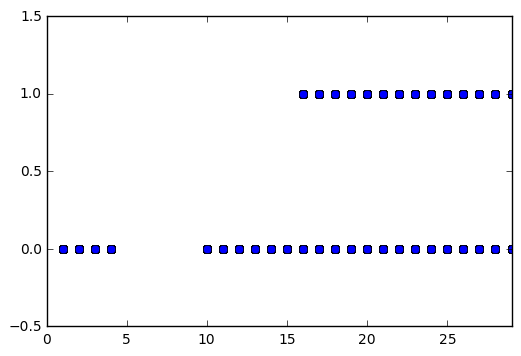

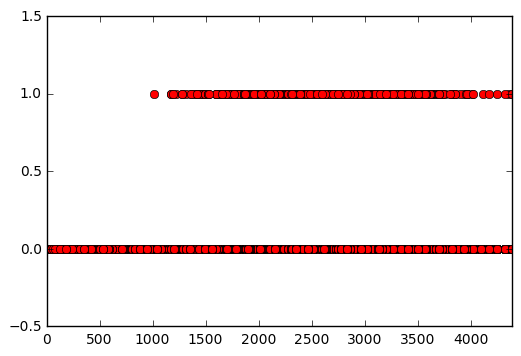

total_order_value     return_flag
(0, 1096.114]         0              17615
                      1                  1
(1096.114, 2192.229]  0              13391
                      1                220
(2192.229, 3288.343]  0              14372
                      1                360
Name: user_signup_date, dtype: int64

In [6]:
x = np.asarray(skimFrame['total_item_count'])
x2 = np.asarray(skimFrame['total_order_value'])
y = np.asarray(quantFrame['return_flag'])
plt.plot(x, y, 'o')
plt.axis([0, skimFrame['total_item_count'].max(), -0.5, 1.5])
plt.show()
# Across 50,000 training examples, returns were only made if total_item_count was greater than 15. 
# This would be another fork in my decision tree. 

plt.plot(x2, y, 'ro')
plt.axis([0, skimFrame['total_order_value'].max(), -0.5, 1.5])
plt.show()
# Like 'total_item_count', there appears to be a lower bound (1000) on this feature to even be considered for a return.

col = skimFrame["total_order_value"]
skimFrame['user_signup_date'].groupby([pd.cut(col, np.arange(0, col.max(), col.max() / 4)), skimFrame['return_flag']]).count()



## *Part 2*
After my analysis of the quantitative features (booleans included), I moved onto working with datetime data. I performed the same kind of analysis as I did with the regular quantitative features. I made the assumption that the intrinsic dates were not as important as the spreads between them.


In [7]:
"""
We're going to look to date features now to find good quantitative features. 
    - After researching reverse logistics and RTO, I think it's reasonable to exclude these dates from 
    consideration since if this is realistic, no person would take into account either of these for making returns.
    - user_signup_date does not seem to be important when considering if a return is made.
    - The dates themselves are not as important as the spreads between them as this is what people actually notice. 
        + Let's make 'order_created_date' as t = 0 for an order. """

timeFeatures = ['last_active_date', 'last_purchase_date', 'last_return_date',
               'promised_date', 'pickup_confirmation_date', 'delivered_date',
               'cancelled_date', 'courier_onboarding_date']

scale = lambda x : x.seconds if hasattr(x, "seconds") else x # to avoid errors with NaT
clean = lambda x : None if x == -9223372036854775808 else x # after changing to int, NaT's become that number

for feature in timeFeatures:
    newSeries = pd.to_datetime(skimFrame[feature]) - pd.to_datetime(skimFrame['order_created_date'])
    skimFrame.loc[:, feature] = newSeries.apply(scale).astype(int).apply(clean)


In [8]:
pd.DataFrame(data={
        'minimum times' : skimFrame[timeFeatures].min(),
        'max times (since order)' : skimFrame[timeFeatures].max(),
        'median times' : skimFrame[timeFeatures].median(),
        'mean times' : skimFrame[timeFeatures].mean()
    })

# order_created_date was evidently a good choice since all the times are nonnegative.
# all of these times appear to be very nearly normally distributed. 

,max times (since order),mean times,median times,minimum times
last_active_date,61320.0,32327.635200,32460.0,2340.0
last_purchase_date,21540.0,10832.152800,10860.0,0.0
last_return_date,41640.0,21539.517600,21480.0,120.0
promised_date,32280.0,16137.837047,16080.0,0.0
pickup_confirmation_date,3540.0,1771.891307,1800.0,0.0
delivered_date,53820.0,26969.437297,27000.0,60.0
cancelled_date,75000.0,37804.908000,37860.0,360.0
courier_onboarding_date,86340.0,43168.602000,43200.0,0.0


In [9]:
unhelpfulTimeFeatures = ["rto_date", "rto_delivered_date", 'reverse_logistics_booked_date', 
                        'reverse_logistics_date', 'reverse_logistics_delivered_date', 
                        'user_signup_date']

# going to check for correlations amongst time features now.
timeCorrelations = skimFrame[timeFeatures + ['return_flag']].corr()
for i in range(9):
	timeCorrelations.iloc[i,i] = 0.0
relevantTimeCorrelations = pd.DataFrame(data={'miminum correlation' : timeCorrelations.min(), 
                                              'maximum correlation' : timeCorrelations.max(),
                                              'correlations with return flag' : timeCorrelations['return_flag']})
relevantTimeCorrelations

,correlations with return flag,maximum correlation,miminum correlation
last_active_date,-0.001169,0.810480,-0.005322
last_purchase_date,0.001878,0.703748,-0.006608
last_return_date,0.001055,0.810480,-0.010394
promised_date,-0.002200,0.668709,-0.002200
pickup_confirmation_date,-0.003140,0.145246,-0.010394
delivered_date,-0.001349,0.820568,-0.001349
cancelled_date,-0.001037,0.820568,-0.001037
courier_onboarding_date,0.002916,0.002916,-0.002975
return_flag,0.000000,0.002916,-0.003140


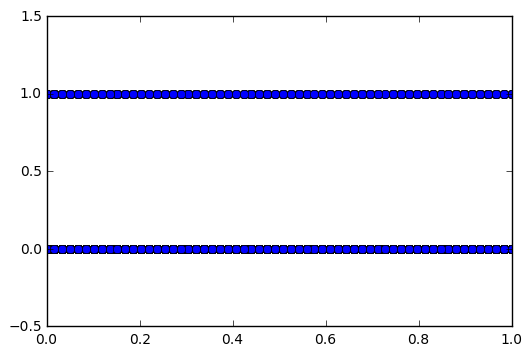

array([ 61320.,  21540.,  41640.,  32280.,   3540.,  53820.,  75000.,
        86340.])

In [10]:
# highest pairwise correlation is r = 0.820568... going to keep all of the features just to be safe. 
# none of the time features correlate well with return_flag... 
skimFrame = skimFrame.drop(unhelpfulTimeFeatures + ['order_created_date'], axis=1)
skimFrame.to_csv("skimDataset2.csv")
newFeatures = ['last_active_date', 'last_purchase_date', 'last_return_date', 'promised_date',
 'pickup_confirmation_date', 'delivered_date', 'cancelled_date', 'courier_onboarding_date']

maxTimes = np.ones(len(newFeatures))
for i in range(len(newFeatures)):
    maxValue = skimFrame[newFeatures[i]].max()
    maxTimes[i] = maxValue
    quantFrame.loc[:,newFeatures[i]] = skimFrame[newFeatures[i]] / float(maxValue)

x = np.asarray(quantFrame['pickup_confirmation_date'])
y = np.asarray(quantFrame['return_flag'])
plt.plot(x, y, 'o')
plt.axis([0, 1, -0.5, 1.5])
plt.show()
# all of the time features will reveal something like this. 

maxTimes

In [11]:
# I'll take all of the time features negatively and positively correlated with returns and combine them respectively.
df = skimFrame
skimFrame.loc[:, "negative_time"] = df['last_active_date'].add(df['promised_date'].add(
    df['pickup_confirmation_date'].add(df['delivered_date'].add(df['cancelled_date']))))
skimFrame.loc[:, 'positive_time'] = df['last_purchase_date'].add(df['last_return_date'].add(
    df['courier_onboarding_date']))

localFrame = pd.DataFrame(data={'positive_time' : skimFrame['positive_time'],
                               'negative_time' : skimFrame['negative_time'],
                               'return_flag' : skimFrame['return_flag']})
for i in range(2):
    feature = localFrame.axes[1][i]
    maxValue = localFrame[feature].max()
    localFrame.loc[:,feature] = localFrame[feature] / float(maxValue)

timeCorrelations = localFrame.corr()
for i in range(3):
    timeCorrelations.iloc[i,i] = 0.0
relevantTimeCorrelations = pd.DataFrame(data={'miminum correlation' : timeCorrelations.min(), 
                                              'maximum correlation' : timeCorrelations.max(),
                                              'correlations with return flag' : timeCorrelations['return_flag']})
relevantTimeCorrelations.loc[['positive_time', 'negative_time'], :]

,correlations with return flag,maximum correlation,miminum correlation
positive_time,0.003278,0.144531,0.000000
negative_time,-0.001532,0.144531,-0.001532



## *Part 3*
Here I worked with the qualitative features by examining their posterior probabilities to see if they were worth encoding into numerical features. In the training data, the rate of returns was 1.37%.


In [12]:
# That experiment did not yield anything of value since those correlation values are not much better than anything before.
# Hence I did not create positive_time, negative_time as features in quantFrame.

# I'm going to look through the categorial features to see if it's worth it to do one-hot encoding for any of them. 
# In each of the groupby's, I check to see proportions of returns and see if there is signficant intercategorical variance.

skimFrame['total_visits'].groupby([skimFrame['payment_processor'],skimFrame['return_flag']]).count()
# will be excluded. almost exactly uniform posterior probabilities, can be proxied by 'issuing_bank'

skimFrame['total_visits'].groupby([skimFrame['shipping_type'],skimFrame['return_flag']]).count() # interesting
# Premium gets most returns (1.54%), Standard gets fewest (1.18%). 

skimFrame['total_visits'].groupby([skimFrame['issuing_bank'],skimFrame['return_flag']]).count() # interesting
# Wells Fargo gets most returns (1.55%), followed by Citigroup (1.43%). Bank of America gets fewest (1.24%)

skimFrame['total_visits'].groupby([skimFrame['transaction_flag'],skimFrame['return_flag']]).count() # mildly interesting
# Fraud gets most returns (1.51%), Expired gets fewest (1.25%)

skimFrame['total_visits'].groupby([skimFrame['product_category'],skimFrame['return_flag']]).count() # shorts?
# Shorts gets most (1.71%), Sweater gets moderate (1.42%), Coat/Pants get least (1.29%, 1.24%)

skimFrame['total_visits'].groupby([skimFrame['product_sub_category'],skimFrame['return_flag']]).count()
# Cotton/Nylon are higher than Polymer/Silk (~1.43% vs. ~1.31%)

skimFrame['total_visits'].groupby([skimFrame['product_features'],skimFrame['return_flag']]).count()
# will be excluded. Hard to characterize, can be proxied by fit_score and product(_sub)_category

skimFrame['total_visits'].groupby([skimFrame['brand_name'],skimFrame['return_flag']]).count() # Raymond  vs. LeeCooper
# LeeCooper gets most (1.52%), Raymond gets least (1.24%)

skimFrame['total_visits'].groupby([skimFrame['courier_name'],skimFrame['return_flag']]).count()
# DHL gets slightly more than the rest (1.43% vs. ~1.34%)

skimFrame['total_visits'].groupby([skimFrame['return_flag'],skimFrame['product_color']]).count()
# will be excluded. Too sparsely scattered. 

skimFrame = skimFrame.drop(['payment_processor', 'product_features', 'product_color'], axis=1)

In [13]:
skimFrame['total_visits'].groupby([skimFrame['shipping_type'],skimFrame['return_flag']]).count()

shipping_type  return_flag
Express        0              12240
               1                171
Premium        0              12376
               1                194
Same Day       0              12356
               1                173
Standard       0              12343
               1                147
Name: total_visits, dtype: int64


## *Part 4*
I consolidated the functions I used to analyze the data so that I could use them quickly to work on the validation and test data.


In [14]:
def prepreprocess(original):
    gender1 = lambda x : 1 if x == "m" else 0
    gender2 = lambda x : 1 if x == "Men" else 0

    original.loc[:, 'user_gender'] = original['user_gender'].apply(gender1)
    original.loc[:, 'product_attribute_gender'] = original['product_attribute_gender'].apply(gender2)

    # convert the one feature that has boolean values into zero-one
    original.loc[:, 'fit_flag'] = original['fit_flag'].astype(int)

    # create a new feature -> abs(fit_score) + fit_flag since fit_score seems to just be how off the fit is from ideal.
    # Sometimes fit_score = 0 and fit_flag is True. We account for this by adding in the fit_flag value too. 
    original.loc[:, 'fit_score2'] = original['fit_score'].apply(abs) + original['fit_flag']
    
    return original

In [15]:
# The concise pipeline of converting timestamp data into useful, scaled data ready for the ML algorithm.
# This will not be applied to the training set since I've done that above in steps that illustrate my thought process.

def addNewFeatures(original, quantFrame):
    timeFeatures = ['last_active_date', 'last_purchase_date', 'last_return_date', 'promised_date',
     'pickup_confirmation_date', 'delivered_date', 'cancelled_date', 'courier_onboarding_date']
    
    scale = lambda x : x.seconds if hasattr(x, "seconds") else x # to avoid errors with NaT
    clean = lambda x : None if x == -9223372036854775808 else x # after changing to int, NaT's become that number

    for i in range(len(timeFeatures)):
        newSeries = pd.to_datetime(original[timeFeatures[i]]) - pd.to_datetime(original['order_created_date'])
        newSeries = newSeries.apply(scale).astype(int).apply(clean)
        quantFrame.loc[:, timeFeatures[i]] = newSeries / maxTimes[i]
    
    return quantFrame

In [16]:
# Another method to add new features to the dataFrame housing the data eventually meant for the ML algorithm.
# First I will apply it to the training set, and later again to the validation and test sets.

def addMoreNewFeatures(original, quantFrame):
    premium_shipping = lambda x : 1 if x == "Premium" else 0
    standard_shipping = lambda x : 1 if x == "Standard" else 0
    wells_fargo = lambda x : 1 if x == "Wells Fargo" else 0
    citigroup = lambda x : 1 if x == "Citigroup" else 0
    bank_of_america = lambda x : 1 if x == "Bank of America" else 0
    fraud = lambda x : 1 if x == "Fraud" else 0
    expired = lambda x : 1 if x == "Expired" else 0
    shorts = lambda x : 1 if x == "Shorts" else 0
    sweater = lambda x : 1 if x == "Sweater" else 0
    coatpants = lambda x : 1 if x == "Coat" or x == "Pants" else 0
    cottonnylon = lambda x : 1 if x == "Cotton" or x == "Nylon" else 0
    leecooper = lambda x : 1 if x == "LeeCooper" else 0
    raymond = lambda x : 1 if x == "Raymond" else 0
    dhl = lambda x : 1 if x == "DHL" else 0

    quantFrame.loc[:, 'premium_shipping'] = original['shipping_type'].apply(premium_shipping)
    quantFrame.loc[:, 'standard_shipping'] = original['shipping_type'].apply(standard_shipping)

    quantFrame.loc[:, 'Wells_Fargo'] = original['issuing_bank'].apply(wells_fargo)
    quantFrame.loc[:, 'Citigroup'] = original['issuing_bank'].apply(citigroup)
    quantFrame.loc[:, 'Bank_of_America'] = original['issuing_bank'].apply(bank_of_america)

    quantFrame.loc[:, 'fraud'] = original['transaction_flag'].apply(fraud)
    quantFrame.loc[:, 'expired'] = original['transaction_flag'].apply(expired)

    quantFrame.loc[:, 'shorts'] = original['product_category'].apply(shorts)
    quantFrame.loc[:, 'sweater'] = original['product_category'].apply(sweater)
    quantFrame.loc[:, 'coat/pants'] = original['product_category'].apply(coatpants)
    
    quantFrame.loc[:, 'cotton/nylon'] = original['product_sub_category'].apply(cottonnylon)

    quantFrame.loc[:, 'LeeCooper'] = original['brand_name'].apply(leecooper)
    quantFrame.loc[:, 'Raymond'] = original['brand_name'].apply(raymond)

    quantFrame.loc[:, 'DHL'] = original['courier_name'].apply(dhl)
    return quantFrame
    


## *Part 5*
I used the SVC class from the sklearn's SVM module, which uses the RBF kernel and a default C value of 1. I fit the classifier to the training data and then found a training accuracy of 98.63%. I wasn't really impressed since 98.63% of the data was in one class (not returned). Then I performed validation which gave me strange results. Afterward, I got a testing accuracy of 98.74%. Again, though, this was nearly exactly the divide in the data class-wise. This leads me to believe that the SVM was not an effective classification method. 


In [18]:
from sklearn.svm import SVC
quantFrame = addMoreNewFeatures(skimFrame, quantFrame)
cleanFrame = quantFrame.dropna()
print(cleanFrame.axes[1])
svmData = cleanFrame.drop(['return_flag'], axis=1).values
svmTargets = cleanFrame['return_flag'].values

print(svmData.shape)
print(svmTargets.shape)
classifier = SVC()
classifier.fit(svmData, svmTargets)
classifier.score(svmData, svmTargets)

Index(['total_visits', 'total_orders', 'last_purchase_value',
       'high_value_customer', 'user_age', 'user_gender', 'total_order_value',
       'total_item_count', 'product_price', 'product_discount',
       'shipping_fees', 'transaction_fees', 'product_length',
       'product_breadth', 'product_height', 'product_weight',
       'product_attribute_gender', 'shipment_weight', 'heavy',
       'delivery_attempt_count', 'user_rating', 'user_review_sentiment_score',
       'return_flag', 'fit_flag', 'fit_score2', 'last_active_date',
       'last_purchase_date', 'last_return_date', 'promised_date',
       'pickup_confirmation_date', 'delivered_date', 'cancelled_date',
       'courier_onboarding_date', 'premium_shipping', 'standard_shipping',
       'Wells_Fargo', 'Citigroup', 'Bank_of_America', 'fraud', 'expired',
       'shorts', 'sweater', 'coat/pants', 'cotton/nylon', 'LeeCooper',
       'Raymond', 'DHL'],
      dtype='object')
(49708, 46)
(49708,)


0.98627987446688659

In [ ]:
# I'm going to perform validation now on 20000 entries. 
# The hsyperparameter I'll be adjusting is the "C" which is used in soft-margin SVM's. 

featuresToRemove = unhelpfulFeatures + redundantFeatures + unhelpfulTimeFeatures
cvalues = [0.1, 0.2, 1/3, 0.5, 0.75, 1, 1.5, 2, 3, 5]
for x in cvalues:
    validationFrame = prepreprocess(pd.read_csv("Dataset.csv").loc[:20000])
    validationFrame = validationFrame.drop(featuresToRemove, axis=1)
    validationQuantFrame = validationFrame.select_dtypes(exclude=['object'])
    validationQuantFrame = addNewFeatures(validationFrame, validationQuantFrame)
    validationQuantFrame = addMoreNewFeatures(validationFrame, validationQuantFrame)
    
    cleanValidationFrame = validationQuantFrame.dropna()
    validationSVMData = cleanValidationFrame.drop(['return_flag'], axis=1).values
    validationSVMTargets = cleanValidationFrame['return_flag'].values
    classifier = SVC(C=x, probability=True, verbose=True)
    classifier.fit(svmData, svmTargets) # refer to cell above - used for training set error.
    score = classifier.score(validationSVMData, validationSVMTargets) * 100
    print("Accuracy For C value of %s was %s" % (x, score))

In [30]:
# Not sure why, but the validation accuracy was the same for all values of C. 
# Going to run the SVM on the test set now. 
featuresToRemove = unhelpfulFeatures + redundantFeatures + unhelpfulTimeFeatures
testFrame = prepreprocess(pd.read_csv("Dataset.csv").loc[20000:50000])
testFrame = testFrame.drop(featuresToRemove, axis=1)
testQuantFrame = testFrame.select_dtypes(exclude=['object'])
testQuantFrame = addNewFeatures(testFrame, testQuantFrame)
testQuantFrame = addMoreNewFeatures(testFrame, testQuantFrame)
testQuantFrame.axes[1]

cleanTestFrame = testQuantFrame.dropna()
testsvmData = cleanTestFrame.drop(['return_flag'], axis=1).values
testsvmTargets = cleanTestFrame['return_flag'].values
testScore = classifier.score(testsvmData, testsvmTargets) * 100
print("Accuracy on test set is %s percent" % (testScore))

/Users/neelkant/anaconda3/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/neelkant/anaconda3/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Accuracy on test set is 98.7373145326 percent


In [10]:
returnTest = pd.read_csv("Dataset.csv").loc[20000:50000]
returnTest['fit_flag'].groupby(returnTest['return_flag']).count()

return_flag
0    29622
1      379
Name: fit_flag, dtype: int64

## *Part 6*
Dissatisfied with the SVM results, I went back to the drawing board by taking all of the quantitative features and feeding them through a SVD algorithm to see if there was a better way to featurize the data.

In [23]:
from sklearn.decomposition import TruncatedSVD
featureMaker = TruncatedSVD(n_components=20)
svdTraining = featureMaker.fit_transform(svmData, svmTargets) # cleanFrame - cleaned out quantFrame (beginning of part 5).
svdClassifier = SVC()
svdClassifier.fit(svdTraining, svmTargets)
svdClassifier.score(svdTraining, svmTargets)

0.98627987446688659

In [27]:
# I got exactly the same training accuracy even with SVD to help out... 
featureMaker.explained_variance_ratio_

array([ 0.02079959,  0.07905295,  0.05300763,  0.05227007,  0.05148185,
        0.05125846,  0.04997242,  0.04877019,  0.04143261,  0.03974792,
        0.03902474,  0.03843673,  0.03585154,  0.03458227,  0.03326223,
        0.0260064 ,  0.02559632,  0.02519793,  0.02421171,  0.0211394 ])

In [31]:
# Seems like a pretty solid balance between the different features.
svdClassifier.score(featureMaker.transform(testsvmData), testsvmTargets)

0.98737314532605425

In [ ]:
# Got exactly the same test accuracy... 

## *Conclusion*
Since I got exactly the same training/test accuracy with just the regular features and the SVD transform, I'm comfortable saying that the issue is more likely in the choice of model (SVM) than the featurization. I think decision trees would be the next model I would explore. 